In [1]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import torch
import time
from peft import get_peft_model, LoraConfig


# from datasets import load_dataset, load_metric
from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [3]:
# for dirname, _, filenames in os.walk('G:\\Hate Speech'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Preface
The majority of the code in this notebook is taken from <br>
1: [BERT with HuggingFace Transformers, kaggle](https://www.kaggle.com/code/tuckerarrants/bert-with-huggingface-transformers) <br>
2: [BERT Fine-Tuning Tutorial with PyTorch
By Chris McCormick and Nick Ryan, google colab](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP?usp=sharing)

In [2]:
CLEAN_TWEETS = False

# Importing library and checking GPU

In [3]:

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060


In [6]:
!pip install transformers

Installing Hugging face lib, but look like they already interaged in

In [4]:
df = pd.read_csv('G:\\Hate Speech\\labeled_data.csv')

In [5]:
# df = pd.read_csv('G:\\Hate Speech\\labeled_data.csv')

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 24,783



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
6572,6757,3,0,3,0,1,@lil_TR1LL can't wait 2 see my bitch tmrw #gat...
4869,5010,9,0,9,0,1,@Tee_Bizzle shut up bitch
4771,4910,3,0,3,0,1,@SteveWorks4You ...you are a lazy redneck. Get...
7240,7447,3,0,3,0,1,@usweekly every1 is so over the bigass bitches!!
9263,9519,3,0,3,0,1,Fuck niggah add it up..&gt;&gt;&gt;
15082,15439,3,0,3,0,1,"RT @EARLmontana: Put that pussy on me, make me..."
19773,20213,3,0,3,0,1,RT @o_youmad: You a hoe &#8220;@VillageBae: I ...
13097,13421,3,0,3,0,1,"My niccas on sum spooky shit, hide n a cut pop..."
12064,12371,3,0,1,2,2,Jihadis Turn Washington National Cathedral Int...
3273,3359,3,0,3,0,1,@Gloryyyy18 brooooo I miss you bitch


In the [class] collum: <br>
0 prefer to hate speech <br>
1 is offensive <br>
2 is neither

# Preprocessing

In [6]:
#strip tweet related character
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
#check functionality
print(df['tweet'][1])
strip_all_entities(df['tweet'][1])

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!


<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\User\AppData\Local\Temp\ipykernel_13388\3965529566.py:3: SyntaxWarning: invalid escape sequence '\w'
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())


'RT boy dats cold tyga dwn bad for cuffin dat hoe in the 1st place'

In [7]:
if CLEAN_TWEETS == False:
    df['tweet']=df['tweet'].apply(strip_all_entities)

In [8]:
sentences = df['tweet'].values
labels = df['class'].values

# Train Test Val split

In [12]:
!pip install scikit-learn

In [9]:
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)

In [10]:
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

In [11]:
# Get the lists of sentences and their labels.
trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

## tokenization

In [24]:
print('loading Albert tokenizer...')
from transformers import AlbertTokenizer, AlbertForSequenceClassification

# Load the Albert tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)


loading Albert tokenizer...


In [25]:
enc_exp = tokenizer.encode('My name is Quan')
dec_exp = tokenizer.decode(enc_exp).lower()
print(enc_exp)
print(dec_exp)

[2, 51, 204, 25, 9836, 3]
[cls] my name is quan[sep]


## padding & masking

In [26]:
print('Max array length: ', max([len(i) for i in sentences]))

Max array length:  581


In [27]:
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>100:
        count1+=1
    if len(i)>200:
        count2+=1
    if len(i)>300:
        count3+=1
print('number of array longer than 100: ', count1)
print('number of array longer than 200: ', count2)
print('number of array longer than 300: ', count3)

number of array longer than 100:  5713
number of array longer than 200:  23
number of array longer than 300:  7


In [28]:
# from statistics import mean

# token_len = []
# for i in sentences:
#     if len(i)>100 and len(i)<200:
#         enc = tokenizer.encode(i)
#         token_len.append(len(enc))
# print('average token length: ', mean(token_len))
# print('maximum token length: ', max(token_len))

--output-- <br>
average token length:  31.558446124099138 <br>
maximum token length:  83

In [29]:
# count = 0
# for i in token_len:
#     if i > 64:
#         count+=1
# print('number of sentence longer than 64 words:', count)

--output-- <br>
number of sentence longer than 64 words: 14

In [30]:
def albert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i].lower(),
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

In [31]:
print(len(sentences),len(trn_sentences),len(tst_sentences),len(val_sentences))

24783 19826 2478 2479


In [32]:
MAX_LEN = 64
train_inputs, train_masks = albert_encode(trn_sentences,MAX_LEN)

test_inputs, test_masks = albert_encode(tst_sentences,MAX_LEN)

validation_inputs, validation_masks = albert_encode(val_sentences,MAX_LEN)

## convert data to pytorch datatype

In [33]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

C:\Users\User\AppData\Local\Temp\ipykernel_13388\1696369575.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
C:\Users\User\AppData\Local\Temp\ipykernel_13388\1696369575.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_labels = torch.tensor(validation_labels)


In [34]:


# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# RoBERTa for sequence classification

In [35]:
from transformers import AlbertForSequenceClassification, AlbertConfig

model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
lora_config = LoraConfig(
    r=16, 
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1, 
    bias="none" 
)

model = get_peft_model(model, lora_config)


In [37]:
# Tell pytorch to run this model on the GPU.
model.cuda()

PeftModel(
  (base_model): LoraModel(
    (model): AlbertForSequenceClassification(
      (albert): AlbertModel(
        (embeddings): AlbertEmbeddings(
          (word_embeddings): Embedding(30000, 128, padding_idx=0)
          (position_embeddings): Embedding(512, 128)
          (token_type_embeddings): Embedding(2, 128)
          (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (encoder): AlbertTransformer(
          (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
          (albert_layer_groups): ModuleList(
            (0): AlbertLayerGroup(
              (albert_layers): ModuleList(
                (0): AlbertLayer(
                  (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                  (attention): AlbertAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=768, out

## optimizer

In [38]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8) 

In [39]:
from transformers import get_linear_schedule_with_warmup

epochs = 30

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

## training loop

In [40]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

training_start_time = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Add these lines
    epoch_start_time = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Time taken for epoch {epoch_i + 1}: {epoch_time:.2f} seconds')

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    total_time = time.time() - training_start_time
    print(f'Total training time: {total_time:.2f} seconds')

print("")
print("Training complete!")


======== Epoch 1 / 30 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:08.
  Batch    80  of    620.    Elapsed: 0:00:16.
  Batch   120  of    620.    Elapsed: 0:00:23.
  Batch   160  of    620.    Elapsed: 0:00:30.
  Batch   200  of    620.    Elapsed: 0:00:38.
  Batch   240  of    620.    Elapsed: 0:00:45.
  Batch   280  of    620.    Elapsed: 0:00:53.
  Batch   320  of    620.    Elapsed: 0:01:00.
  Batch   360  of    620.    Elapsed: 0:01:08.
  Batch   400  of    620.    Elapsed: 0:01:15.
  Batch   440  of    620.    Elapsed: 0:01:23.
  Batch   480  of    620.    Elapsed: 0:01:30.
  Batch   520  of    620.    Elapsed: 0:01:38.
  Batch   560  of    620.    Elapsed: 0:01:45.
  Batch   600  of    620.    Elapsed: 0:01:53.

  Average training loss: 0.82
Time taken for epoch 1: 116.44 seconds

Running Validation...
  Accuracy: 0.77
  Validation took: 0:00:07
Total training time: 123.42 seconds

======== Epoch 2 / 30 ========
Training...
  Batch    40  of    620.    Elaps

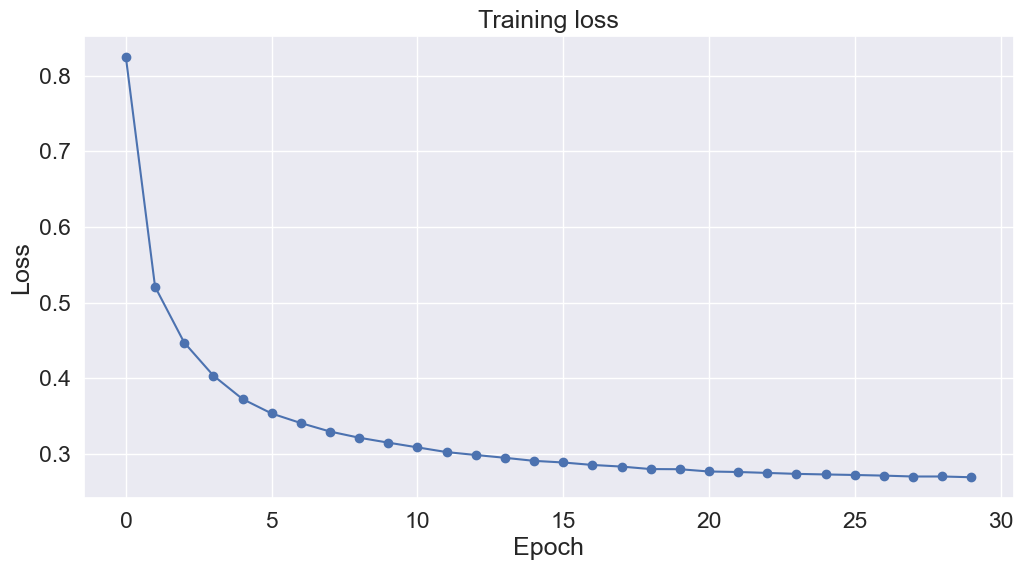

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# On test set

In [44]:
test_inputs, test_masks = albert_encode(tst_sentences,MAX_LEN)

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,478 test sentences...
    DONE.


## Matthew's correlation coefficient
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [46]:
from sklearn.metrics import matthews_corrcoef, classification_report

In [47]:

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 3-column ndarray (one column for "0"
  # one for "1" and one for "2"). Pick the label with the highest value and turn this
  # in to a list of 0s, 1s, 2s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

In [48]:
# Combine the predictions for each batch into a single list of 0s,1s, 2s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.706


## confusion matrix

In [51]:
class_names= ["Hate", "Offensive", "Neither"]

In [52]:
print(classification_report(test_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.0065    0.0127       155
           1     0.9143    0.9641    0.9385      1893
           2     0.8083    0.9023    0.8527       430

    accuracy                         0.8935      2478
   macro avg     0.7409    0.6243    0.6013      2478
weighted avg     0.8700    0.8935    0.8657      2478



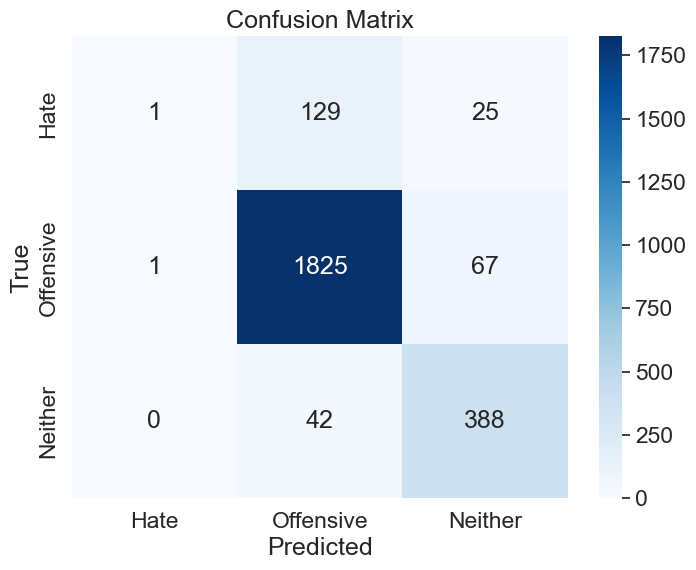

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(test_labels, flat_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

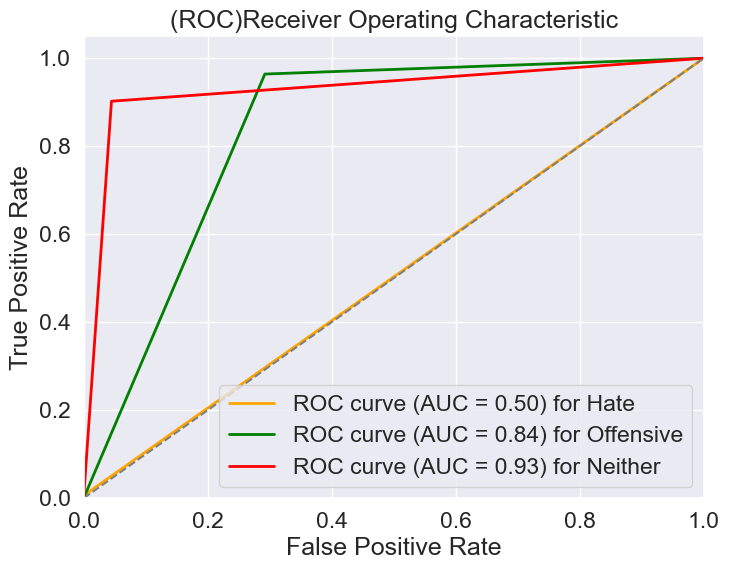

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = len(class_names)

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(test_labels) == i, np.array(flat_predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()